### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import networkx as nx
from networkx.convert_matrix import from_numpy_matrix
from networkx.algorithms.centrality import degree_centrality, in_degree_centrality, out_degree_centrality, eigenvector_centrality, katz_centrality, closeness_centrality, betweenness_centrality 

import imageio

### Read corr Matrices which we will use as adj matrices

In [2]:
# We have window sizes of 7, 30, 90, 180 days available
windowsize = 90
filename_matrices = 'Adj_Matrices/Top25CC_CorMatrix_rollingwindow_'+str(windowsize)+'.csv'

In [3]:
corr_matrices = pd.read_csv(filename_matrices, index_col='date')
# drop redundant column, get rid of infinite values, 
# ignore the first (windowsize) time steps, fill NAs with 0
corr_matrices = corr_matrices.drop('CC', axis = 1).replace([np.inf, -np.inf], np.nan)[25*windowsize:].fillna(0)
corr_matrices.index = pd.to_datetime(corr_matrices.index)

In [4]:
dates = np.unique(corr_matrices.index)

In [5]:
# CCs that we use, consituents from CRIX Q1 2019
constits_latest = ['ada', 'bat', 'bch', 'bnb', 'bsv', 'btc', 'dash', 'eos', 'etc',
       'eth', 'ltc', 'miota', 'mkr', 'neo', 'okb', 'ont', 'trx', 'usdt',
       'vet', 'xem', 'xlm', 'xmr', 'xrp', 'xtz', 'zec']

### Make threshold

In [34]:
# factor is multiple of std from mean
# can be positive or negative
# can be float
factor = 1
threshold = (corr_matrices.values.flatten().mean()
             + factor * (corr_matrices.values.flatten().std()))

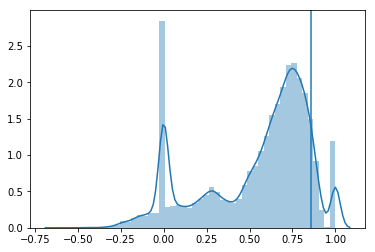

In [35]:
sns.distplot(corr_matrices.values.flatten())
plt.axvline(threshold)
plt.show()

### Make degreeness over time table (data frame, df)

In [36]:
degree_df = pd.DataFrame(columns=constits_latest+['n_edges'])
for date in dates:
    adj_matrix = corr_matrices.loc[date]
    # remove self-loops
    adj_matrix = np.where((adj_matrix<=1.000001) & (adj_matrix>=0.99999),0,adj_matrix)
    # replace values that are below threshold
    adj_matrix = np.where(adj_matrix <= threshold, 0, adj_matrix)
    # create undirected graph from adj_matrix
    graph = from_numpy_matrix(adj_matrix, parallel_edges=False, create_using= nx.Graph())
    # set names to crypots
    graph = nx.relabel.relabel_nodes(graph, dict(zip(range(len(constits_latest)), constits_latest)))
    # get DC
    d_C = degree_centrality(graph)
    degreeness = np.array(list(d_C.values()))
    degree_df.loc[date] = np.append(degreeness, graph.number_of_edges())

In [29]:
top_5_cryptos = ['btc', 'eth', 'xrp', 'bch', 'eos']

### Make plots

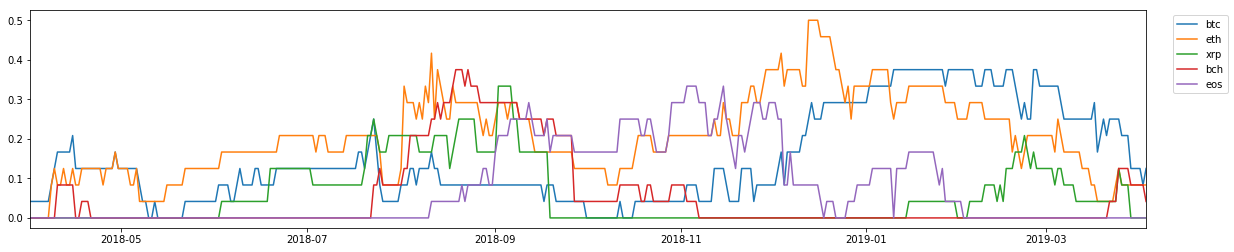

In [37]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20,4)
for cc in top_5_cryptos:
    ax.plot(degree_df[cc], label = cc)
ax.set_xlim(dates[0], dates[-1])
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

plt.savefig('plots/Top_5_CC_degreeness_window_'+str(windowsize)+'_factor_'+str(factor)+'.png', dpi = 150, transparent = True)
plt.show()

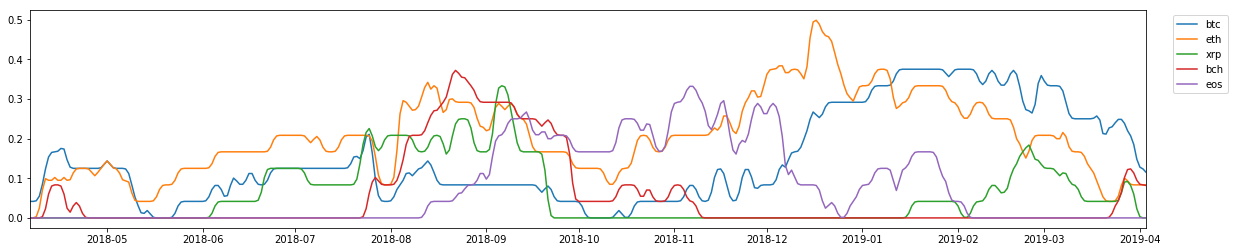

In [38]:
# Smoothed version
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20,4)
hamming_window =  5
for cc in top_5_cryptos:
    ax.plot(degree_df[cc].rolling(window = hamming_window, win_type ='hamming').mean(), label = cc)
ax.set_xlim(dates[0+hamming_window], dates[-1])
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

plt.savefig('plots/Hamming_Top_5_CC_degreeness_window_'+str(windowsize)+'_factor_'+str(factor)+'.png', dpi = 150, transparent = True)
plt.show()

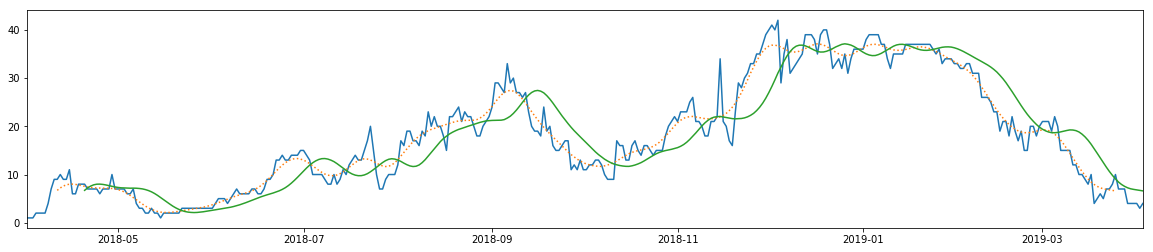

In [46]:
# plot n_edges
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20,4)
ax.plot(degree_df.n_edges)
ax.plot(degree_df.n_edges.rolling(window = 20, win_type ='hamming', center = True).mean(), linestyle=':')
ax.plot(degree_df.n_edges.rolling(window = 20, win_type ='hamming', center = False).mean())

ax.set_xlim(dates[0], dates[-1])

plt.savefig('plots/n_Edges_over_times_window'+str(windowsize)+'_factor_'+str(factor)+'.png', dpi = 150, transparent = True)
plt.show()

### Make Movie

In [ ]:
# make figure for drawing
fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)


# define t_span = n(t)
t_span = dates.size

# make first graph for arranging nodes and labels
corr_matrices.loc[dates[0]]
graph = from_numpy_matrix(adj_matrix, parallel_edges=False, create_using= nx.Graph())
graph = nx.relabel.relabel_nodes(graph, dict(zip(range(len(constits_latest)), constits_latest)))

pos_og =  nx.circular_layout(graph, scale=2)
pos = nx.circular_layout(graph, scale=2)
for p in pos:  # raise text positions
    if pos[p][1]>1:
        pos[p][1] += 0.15
    if pos[p][1]<-1:
        pos[p][1] -= 0.15
    elif pos[p][0]<0:
        pos[p][0] -= 0.3
    else:
        pos[p][0]+=0.3

for t in range(t_span):
    ax.cla()
    ax.set_ymargin(0.15)
    ax.set_xmargin(0.15)
    ax.set_title(str(dates[t])[:10])

    adj_matrix = corr_matrices.loc[dates[t]]
    # remove self-loops
    adj_matrix = np.where((adj_matrix<=1.000001) & (adj_matrix>=0.99999),0,adj_matrix)
    # replace values that are below threshold
    adj_matrix = np.where(adj_matrix <= threshold, 0, adj_matrix)
    # create undirected graph from adj_matrix
    graph = from_numpy_matrix(adj_matrix, parallel_edges=False, create_using= nx.Graph())
    # set names to crypots
    graph = nx.relabel.relabel_nodes(graph, dict(zip(range(len(constits_latest)), constits_latest)))
    # get DC
    d_C = degree_centrality(graph)
    degreeness = np.array(list(d_C.values()))
    
    #check whether we have any edges - calculations below would fail otherwise
    if graph.size() == 0:
        print('Warning: Threshold too high.\nNo edges day {}'.format(dates[t]))
        sizes = 50
    else:
        sizes = 50 + 150*(degreeness/degreeness.max())
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
        weights = (weights-np.min(weights))/(np.max(weights)-np.min(weights))
        weights = 0.3 + 1.2*weights
    # set KeyWordARGumentS
    kwargs = {'arrows':True, 'cmap' :'Reds',
             'ax':ax,
             'node_color':degreeness, 'node_size' : sizes, 'width' : weights}
    nx.draw(graph, pos_og, with_labels= False,**kwargs)
    nx.draw_networkx_labels(graph, pos)
    filename='RENDERED_IMAGES/'+ str(t)+'_th_frame_formovie.png'
    plt.savefig(filename, dpi=150, transparent=False)
    if t%10==0:
        print('RENDERED FRAME: {} / {} - day : {}'.format(t, t_span, dates[t]))
    
print('DONE')
plt.show()

In [ ]:
#make movie from rendered frames
images = []
for t in range(t_span):
    filename = 'RENDERED_IMAGES/'+ str(t)+'_th_frame_formovie.png'
    images.append(imageio.imread(filename))
    if t%20 ==0:
        print('READ FRAME: {} / {} - day : {}'.format(t, t_span, dates[t]))
print('Read all frames, rendering movie now')
#kwargs = { 'duration': 0.3 }
imageio.mimsave('movies\CRIX_corr_network_movie_windowsize_' + str(windowsize) + 'd' +'_factor_'+str(factor)+'.mp4', images, fps=16)#, **kwargs)
print('Done!')